# Getting started with cleanair

This is a quick startup guide to get hands on with the data. There is more info on SCOOT in the scoot notebook.

Its probably best to duplicate a notebook if you intend on adding to it.

## Installation

The full installation (including docker) is given in the README of this repo, but here is a quick summary:

### Clone the repository

```bash
git clone https://github.com/alan-turing-institute/clean-air-infrastructure.git
```

### Install cleanair and dependencies

Create a new **python 3.7** conda/pyenv **virtual environment**.

Install the requirements then install cleanair:
```bash
cd clean-air-infrastructure
git checkout -b scoot_notebook
git pull origin scoot_notebook
pip install -r containers/requirements.txt
pip install -e containers
```

> Please check that pip is using the virtual environment you have setup by running `which pip`.

### Plotly and mapbox (for visualisations)

Some of the viz code is written using plotly. In particular the maps of London use mapbox which requires nodejs. Please check that you have [nodejs installed](https://treehouse.github.io/installation-guides/mac/node-mac.html):

```bash
node -v
```

You will need access to a mapbox API key. Sign up to get an account the copy your API token.

Once you have the key, use the following command to place the key in the .secrets folder:

```bash
echo "API_KEY" > terraform/.secrets/.mapbox_token
```

### Test install

Run the import statements below to test everything has installed.

> Ignore the tensorflow warnings. We are currently using an old version of TF.

In [4]:
# check that all of your imports are working
import pandas as pd
import os
from datetime import datetime

# viz
import plotly.express as px

# cleanair modules for scoot
from cleanair.scoot import ScootQuery


## Setup

We need to add some files and configs before you can start running files.

### DB credentials

You will need to create a local secrets file. Run the following to create a file with the database secrets:
```bash
mkdir -p terraform/.secrets
touch terraform/.secrets/db_secrets.json
echo '{
    "username": "<db_username>@<db_server_name>",
    "password": "<db_password>",
    "host": "<db_server_name>.postgres.database.azure.com",
    "port": 5432,
    "db_name": "<dbname>",
    "ssl_mode": "require"
}' >> terraform/.secrets/db_secrets.json
```

Open the file and replace the <> with the secret values which can be found in the keyvault in the `RG_CLEANAIR_INFRASTRUCTURE` Azure resource group. If you don't have access to the vault, ask someone in the cleanair team to help you out.

## Query Scoot

Now that you have DB credentials, you can test out a small query below. This will get aggregated SCOOT data for 12 hours of a day.

In [5]:
# directory to your secrets directory
secrets_dir = "../../terraform/.secrets/"
secretfile = os.path.join(secrets_dir, "db_secrets.json")

# create an object which will query scoot for you
SQ = ScootQuery(secretfile=secretfile)

# run a query
scoot_df = SQ.groupby_datetime_df()

scoot_df.sample(3)

2020-03-24 09:14:58     INFO: Database connection information loaded from <_io.TextIOWrapper name='../../terraform/.secrets/db_secrets.json' mode='r' encoding='UTF-8'>


,measurement_start_utc,measurement_end_utc,sum_n_vehicles_in_interval,avg_occupancy_percentage,avg_congestion_percentage,avg_saturation_percentage,sum_flow_raw_count,sum_occupancy_raw_count,sum_congestion_raw_count,sum_saturation_raw_count
2,2020-02-23 08:00:00,2020-02-23 09:00:00,2099351,5.326745,0.725371,19.551854,363788630,336753212,316854591,271528918
10,2020-02-23 16:00:00,2020-02-23 17:00:00,4207712,13.446754,2.860808,47.825550,367565791,336174358,315250391,307678114
5,2020-02-23 11:00:00,2020-02-23 12:00:00,4057677,12.316402,2.344590,44.887323,369080948,338581988,316824616,308264439


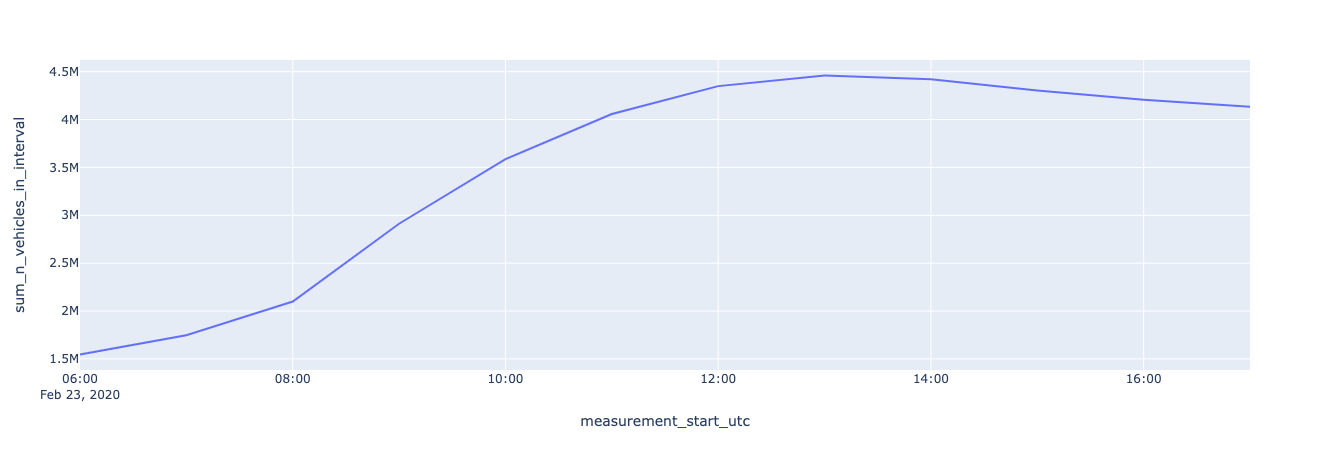

In [6]:
fig = px.line(scoot_df, x="measurement_start_utc", y="sum_n_vehicles_in_interval")
fig.show()